In [22]:
import re
import os
import csv
import time
import nltk
import spacy
import torch
import pickle
import random
import unicodedata
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from faker import Faker
from torch.utils import data
from torch.optim import AdamW
from argparse import Namespace
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModel, get_linear_schedule_with_warmup, AutoTokenizer
nltk.download('stopwords')

os.environ["TOKENIZERS_PARALLELISM"] = "false"
stopwords = set(stopwords.words('english'))
lm_mp = {
    "roberta" : "roberta-base",
    "distilbert" : "distilbert-base-uncased"
}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
faker = Faker('fr_FR')

cities = ['Casablanca', 'Rabat', 'Marrakech', 'Agadir', 'Tanger', 'Oujda', 'Kenitra']

def random_cin():
    return faker.random_uppercase_letter() + faker.random_uppercase_letter() + str(faker.random_number(digits=6, fix_len=True))

def random_cnss():
    return str(faker.random_number(digits=8, fix_len=True))

def introduce_typos(text):
    """Introduce realistic typos in text"""
    if not text or pd.isna(text):
        return text
    
    text = str(text)
    
    # Common typo patterns
    typo_patterns = [
        # Character substitutions (keyboard proximity)
        ('a', 'e'), ('e', 'a'), ('i', 'y'), ('o', '0'), ('0', 'o'),
        ('u', 'i'), ('m', 'n'), ('n', 'm'), ('b', 'v'), ('v', 'b'),
        ('c', 'k'), ('k', 'c'), ('s', 'z'), ('z', 's'),
        # Double letters
        ('l', 'll'), ('s', 'ss'), ('t', 'tt'), ('n', 'nn'),
        # Missing letters (deletions)
        ('th', 't'), ('ch', 'c'), ('qu', 'q'), ('tion', 'ion'),
        # Transpositions
        ('er', 're'), ('le', 'el'), ('on', 'no'), ('it', 'ti'),
    ]
    
    # Apply random typos (30% chance)
    if random.random() < 0.3:
        # Choose random typo type
        typo_type = random.choice(['substitute', 'delete', 'insert', 'transpose'])
        
        if typo_type == 'substitute' and len(text) > 1:
            # Character substitution
            pos = random.randint(0, len(text) - 1)
            chars = list(text)
            old_char = chars[pos].lower()
            
            # Use common substitutions or random
            substitutions = {
                'a': 'e', 'e': 'a', 'i': 'y', 'o': '0', 'u': 'i',
                'm': 'n', 'n': 'm', 'b': 'v', 'v': 'b', 'c': 'k', 'k': 'c'
            }
            
            if old_char in substitutions:
                chars[pos] = substitutions[old_char]
            else:
                # Random nearby character
                nearby_chars = 'abcdefghijklmnopqrstuvwxyz'
                chars[pos] = random.choice(nearby_chars)
            
            text = ''.join(chars)
        
        elif typo_type == 'delete' and len(text) > 2:
            # Delete a character
            pos = random.randint(0, len(text) - 1)
            text = text[:pos] + text[pos+1:]
        
        elif typo_type == 'insert':
            # Insert a character
            pos = random.randint(0, len(text))
            char = random.choice('abcdefghijklmnopqrstuvwxyz')
            text = text[:pos] + char + text[pos:]
        
        elif typo_type == 'transpose' and len(text) > 1:
            # Transpose two adjacent characters
            pos = random.randint(0, len(text) - 2)
            chars = list(text)
            chars[pos], chars[pos+1] = chars[pos+1], chars[pos]
            text = ''.join(chars)
    
    return text

def add_formatting_issues(text):
    """Add realistic formatting issues"""
    if not text or pd.isna(text):
        return text
    
    text = str(text)
    
    # Random formatting issues
    if random.random() < 0.2:
        # Extra spaces
        text = re.sub(r'\s+', '  ', text)
    
    if random.random() < 0.3:
        # Missing spaces
        text = text.replace(' ', '')
    
    if random.random() < 0.2:
        # Random capitalization
        if random.random() < 0.5:
            text = text.upper()
        else:
            text = text.lower()
    
    if random.random() < 0.1:
        # Add random punctuation
        text = text + random.choice(['.', ',', ';', '!'])
    
    return text

def corrupt_phone_number(phone):
    """Add realistic phone number corruption"""
    if not phone or pd.isna(phone):
        return phone
    
    phone = str(phone)
    
    # Common phone number issues
    issues = [
        lambda p: p.replace('+212', ''),  # Remove country code
        lambda p: p.replace(' ', ''),     # Remove spaces
        lambda p: p.replace('-', ''),     # Remove dashes
        lambda p: p.replace('(', '').replace(')', ''),  # Remove parentheses
        lambda p: '0' + p if not p.startswith('0') else p,  # Add leading zero
        lambda p: p[1:] if p.startswith('0') else p,  # Remove leading zero
        lambda p: p.replace('06', '6', 1),  # Remove leading 0 in mobile
        lambda p: p.replace('05', '5', 1),  # Remove leading 0 in landline
    ]
    
    # Apply 1-2 random issues
    num_issues = random.randint(1, 2)
    for _ in range(num_issues):
        issue = random.choice(issues)
        phone = issue(phone)
    
    # Add typos to phone numbers
    phone = introduce_typos(phone)
    
    return phone

def corrupt_email(email):
    """Add realistic email corruption"""
    if not email or pd.isna(email):
        return email
    
    email = str(email)
    
    # Common email issues
    if random.random() < 0.3:
        # Wrong domain
        email = email.replace('@gmail.com', '@gmial.com')
        email = email.replace('@yahoo.com', '@yaho.com')
        email = email.replace('@hotmail.com', '@hotmial.com')
    
    if random.random() < 0.2:
        # Missing @ or .
        if '@' in email:
            email = email.replace('@', '', 1)
        elif '.' in email:
            email = email.replace('.', '', 1)
    
    if random.random() < 0.2:
        # Extra characters
        email = email.replace('@', '@@', 1)
    
    # Add typos
    email = introduce_typos(email)
    
    return email

def corrupt_address(address):
    """Add realistic address corruption"""
    if not address or pd.isna(address):
        return address
    
    address = str(address)
    
    # Common address abbreviations and issues
    abbreviations = {
        'Avenue': 'Ave', 'Boulevard': 'Blvd', 'Street': 'St', 'Road': 'Rd',
        'Rue': 'R.', 'Avenue': 'Av.', 'Boulevard': 'Bd.', 'Place': 'Pl.',
        'Quartier': 'Q.', 'Résidence': 'Rés.', 'Immeuble': 'Imm.',
        'Appartement': 'Apt', 'Numéro': 'N°', 'Bis': 'B'
    }
    
    # Apply abbreviations
    if random.random() < 0.4:
        for full, abbr in abbreviations.items():
            if full in address:
                address = address.replace(full, abbr)
    
    # Add typos
    address = introduce_typos(address)
    
    # Add formatting issues
    address = add_formatting_issues(address)
    
    return address

def add_data_entry_errors(person):
    """Add realistic data entry errors"""
    modified = person.copy()
    
    # Name issues
    if random.random() < 0.4:
        modified["full_name"] = introduce_typos(person["full_name"])
    
    if random.random() < 0.3:
        modified["full_name"] = add_formatting_issues(person["full_name"])
    
    # Email corruption
    if random.random() < 0.3:
        modified["email"] = corrupt_email(person["email"])
    
    # Phone corruption
    if random.random() < 0.4:
        modified["phone"] = corrupt_phone_number(person["phone"])
    
    # Address corruption
    if random.random() < 0.4:
        modified["address"] = corrupt_address(person["address"])
    
    # Employer name issues
    if random.random() < 0.3:
        modified["employer_name"] = introduce_typos(person["employer_name"])
    
    # CIN format variations
    if random.random() < 0.2:
        cin = person["cin"]
        if cin:
            # Remove letters or add spaces
            if random.random() < 0.5:
                modified["cin"] = cin.replace(cin[:2], cin[:2].lower())
            else:
                modified["cin"] = cin[:2] + " " + cin[2:]
    
    # CNSS number issues
    if random.random() < 0.2:
        cnss = person["cnss_number"]
        if cnss:
            # Add dashes or spaces
            if len(cnss) == 8:
                modified["cnss_number"] = cnss[:4] + "-" + cnss[4:]
    
    # Date format variations
    if random.random() < 0.2:
        dob = person["date_of_birth"]
        if dob:
            # Change date format
            from datetime import datetime
            try:
                date_obj = datetime.fromisoformat(dob)
                formats = [
                    "%d/%m/%Y", "%d-%m-%Y", "%Y/%m/%d", "%m/%d/%Y"
                ]
                new_format = random.choice(formats)
                modified["date_of_birth"] = date_obj.strftime(new_format)
            except:
                pass
    
    return modified

def generate_person():
    return {
        "full_name": faker.name(),
        "cin": random_cin(),
        "date_of_birth": faker.date_of_birth(minimum_age=18, maximum_age=65).isoformat(),
        "place_of_birth": random.choice(cities),
        "cnss_number": random_cnss(),
        "email": faker.email(),
        "phone": faker.phone_number(),
        "address": faker.street_address(),
        "city": random.choice(cities),
        "employer_name": faker.company()
    }

def add_light_noise(person):
    """Add light noise to reference table"""
    modified = person.copy()
    
    # Light modifications (20% chance each)
    if random.random() < 0.2:
        modified["full_name"] = person["full_name"].title()  # case change
    
    if random.random() < 0.1:
        modified["email"] = person["email"].lower()
    
    if random.random() < 0.1:
        modified["phone"] = person["phone"].replace(" ", "")  # remove spaces
    
    return modified

def add_heavy_noise(person):
    """Add heavy noise to dataset table with realistic issues"""
    modified = person.copy()
    
    # Apply data entry errors first
    modified = add_data_entry_errors(modified)
    
    # Additional heavy modifications
    if random.random() < 0.6:
        modified["full_name"] = modified["full_name"].lower()  # case change
    
    if random.random() < 0.4:
        modified["address"] = modified["address"].replace("Rue", "R.")  # abbreviation
    
    if random.random() < 0.4:
        employer = modified["employer_name"]
        if employer and len(employer.split()) > 1:
            modified["employer_name"] = employer.split()[0]  # first word only
    
    # Add missing values (realistic missing data patterns)
    missing_probabilities = {
        'email': 0.15,      # Email often missing
        'phone': 0.1,       # Phone sometimes missing
        'address': 0.2,     # Address frequently incomplete
        'employer_name': 0.25,  # Employer often missing
        'cnss_number': 0.3,  # CNSS often missing in informal sectors
    }
    
    for field, prob in missing_probabilities.items():
        if random.random() < prob:
            modified[field] = None
    
    # Partial data corruption (common in real datasets)
    if random.random() < 0.1:
        # Truncated fields
        if modified["full_name"] and len(modified["full_name"]) > 10:
            modified["full_name"] = modified["full_name"][:10] + "..."
    
    if random.random() < 0.05:
        # Wrong data type (numbers as strings, etc.)
        if modified["phone"]:
            modified["phone"] = "TEL: " + str(modified["phone"])
    
    return modified

def create_similar_person(base_person):
    """Create a person that looks similar but is different (hard negative)"""
    similar = generate_person()
    
    # Keep some similar characteristics to make it tricky
    if random.random() < 0.3:
        # Same city
        similar["city"] = base_person["city"]
        similar["place_of_birth"] = base_person["place_of_birth"]
    
    if random.random() < 0.2:
        # Similar name (same first name or last name)
        base_name_parts = base_person["full_name"].split()
        similar_name_parts = similar["full_name"].split()
        if len(base_name_parts) >= 2 and len(similar_name_parts) >= 2:
            # Same first name, different last name
            similar["full_name"] = base_name_parts[0] + " " + similar_name_parts[-1]
    
    if random.random() < 0.1:
        # Similar employer
        similar["employer_name"] = base_person["employer_name"]
    
    if random.random() < 0.05:
        # Similar phone prefix (same area code)
        if base_person["phone"] and similar["phone"]:
            base_prefix = base_person["phone"][:3]
            similar["phone"] = base_prefix + similar["phone"][3:]
    
    return similar

def generate_duplicate_variations(person):
    """Generate multiple variations of the same person (realistic duplicates)"""
    variations = []
    
    # Create 2-4 variations
    num_variations = random.randint(2, 4)
    
    for _ in range(num_variations):
        variation = person.copy()
        
        # Apply different levels of corruption
        corruption_level = random.choice(['light', 'medium', 'heavy'])
        
        if corruption_level == 'light':
            variation = add_light_noise(variation)
        elif corruption_level == 'medium':
            variation = add_data_entry_errors(variation)
        else:  # heavy
            variation = add_heavy_noise(variation)
        
        variations.append(variation)
    
    return variations

def generate_tables(base_path, n_total=2000, match_ratio=0.3):
    """Generate reference table (cleaner) and source table (noisy)"""
    n_matches = int(n_total * match_ratio)
    n_non_matches = n_total - n_matches

    print(f"Generating {n_total} records:")
    print(f"{n_matches} matching pairs ({match_ratio*100:.0f}%)")
    print(f"{n_non_matches} non-matching records")
    print("=" * 50)

    # Create folders
    os.makedirs(os.path.join(base_path, "data"), exist_ok=True)

    # Generate base persons
    base_persons = [generate_person() for _ in range(n_matches)]

    # Reference table: light noise
    reference_table = []
    for i, person in enumerate(base_persons):
        ref_person = add_light_noise(person)
        ref_person['id'] = f"REF_{i:04d}"
        reference_table.append(ref_person)

    # Source table: heavy noise + hard negatives
    source_table = []
    for i, person in enumerate(base_persons):
        src_person = add_heavy_noise(person)
        src_person['id'] = f"SRC_{i:04d}"
        source_table.append(src_person)

    for i in range(n_matches, n_total):
        if random.random() < 0.3:
            base_for_similar = random.choice(base_persons)
            person = create_similar_person(base_for_similar)
        else:
            person = generate_person()

        if random.random() < 0.5:
            person = add_heavy_noise(person)

        person['id'] = f"SRC_{i:04d}"
        source_table.append(person)

    # Ground truth
    ground_truth = []
    for i in range(n_matches):
        ground_truth.append({
            'ref_id': f"REF_{i:04d}",
            'data_id': f"SRC_{i:04d}",
            'match': 1
        })

    for _ in range(n_matches * 2):
        ref_idx = random.randint(0, len(reference_table) - 1)
        data_idx = random.randint(0, len(source_table) - 1)
        ref_id = reference_table[ref_idx]['id']
        data_id = source_table[data_idx]['id']

        if not any(gt['ref_id'] == ref_id and gt['data_id'] == data_id for gt in ground_truth):
            ground_truth.append({'ref_id': ref_id, 'data_id': data_id, 'match': 0})

    # Shuffle
    random.shuffle(reference_table)
    random.shuffle(source_table)

    # Save
    pd.DataFrame(reference_table).to_csv(os.path.join(base_path, "data", "reference_table.csv"), index=False)
    pd.DataFrame(source_table).to_csv(os.path.join(base_path, "data", "source_table.csv"), index=False)
    pd.DataFrame(ground_truth).to_csv(os.path.join(base_path, "data", "ground_truth.csv"), index=False)

    # Print summary
    print("\n📁 Files saved")
    print(f" - Reference: {len(reference_table)} rows")
    print(f" - Source:    {len(source_table)} rows")
    print(f" - Ground Truth: {len(ground_truth)} pairs")
    print(f"   - Matches: {n_matches}")
    print(f"   - Non-matches: {len(ground_truth) - n_matches}")

In [24]:
# ----------- Step 1: Convert CSV to Ditto-style text -----------

def normalize_word(word):
    word = word.lower()
    word = unicodedata.normalize('NFD', word)
    word = ''.join([char for char in word if unicodedata.category(char) != 'Mn'])
    return word
    
def csv_to_ditto_txt(csv_path, out_txt_path):
    df = pd.read_csv(csv_path)
    os.makedirs(os.path.dirname(out_txt_path), exist_ok=True)
    
    with open(out_txt_path, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            fields = [f"COL {normalize_word(col)} VAL {normalize_word(str(val))}" for col, val in row.items() if col != "id"]
            line = " ".join(fields)
            f.write(line + "\n")

# ----------- Step 2: Encode lines using Transformer -----------

def encode_all(input_path, out_path, model, overwrite=True):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    with open(input_path, encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]

    if not os.path.exists(out_path) or overwrite:
        vectors = model.encode(lines, normalize_embeddings=True)
        with open(out_path, "wb") as f:
            pickle.dump(vectors, f)
    else:
        with open(out_path, "rb") as f:
            vectors = pickle.load(f)

    return lines, vectors

# ----------- Step 3: Perform blocked matrix multiplication -----------

def blocked_matmul(mata, matb, threshold=0.95, k=3, batch_size=1024):
    mata = np.array(mata)
    matb = np.array(matb)
    results = []

    for start in tqdm(range(0, len(matb), batch_size)):
        block = matb[start:start + batch_size]
        sim_mat = np.matmul(mata, block.T)
        for j in range(sim_mat.shape[1]):
            top_k_idx = np.argpartition(-sim_mat[:, j], k)[:k]
            for i in top_k_idx:
                sim_score = sim_mat[i][j]
                if sim_score > threshold:
                    results.append((i, j + start, sim_score, 1))
                else:
                    results.append((i, j + start, sim_score, 0))
        
    return results

# ----------- Step 4: Save outputs -----------

def dump_pairs_csv(out_fn, pairs):
    df = pd.DataFrame(pairs, columns=["id_table_a", "id_table_b", "similarity", "label"])
    df.to_csv(out_fn, index=False)

def dump_ditto_txt(out_fn, pairs, entries_a, entries_b):
    with open(out_fn, "w", encoding="utf-8") as f:
        for idx_a, idx_b, _, label in pairs:
            idx_a = int(idx_a)  # convert from float to int
            idx_b = int(idx_b)
            row = f"{entries_a[idx_a]}\t{entries_b[idx_b]}\t{int(label)}\n"
            f.write(row)

def evaluate_blocking_metrics(pairs, ground_truth_path, ref_table_path, data_table_path):
    gt_df = pd.read_csv(ground_truth_path)
    ref_df = pd.read_csv(ref_table_path)
    data_df = pd.read_csv(data_table_path)

    # Build index-to-id maps (based on order of encoding)
    ref_id_map = {i: row["id"] for i, row in ref_df.reset_index().iterrows()}
    data_id_map = {i: row["id"] for i, row in data_df.reset_index().iterrows()}

    # Set of true matches from ground truth
    true_matches = set(zip(gt_df[gt_df["match"] == 1]["ref_id"], gt_df[gt_df["match"] == 1]["data_id"]))

    # Set of predicted matches from blocking
    predicted_pairs = set((ref_id_map[i], data_id_map[j]) for i, j, _, _ in pairs)

    # Set of predicted positives (sim > threshold AND labeled 1 in blocking)
    predicted_positive = set((ref_id_map[i], data_id_map[j]) for i, j, _, label in pairs if label == 1)

    # Recall = % of true matches retrieved
    found_matches = true_matches.intersection(predicted_positive)
    recall = len(found_matches) / len(true_matches) if true_matches else 0

    # Precision = % of predicted matches that are true matches
    precision = len(found_matches) / len(predicted_positive) if predicted_positive else 0

    # Reduction Ratio = 1 - (# blocked pairs / all possible pairs)
    total_possible_pairs = len(ref_df) * len(data_df)
    rr = 1 - (len(pairs) / total_possible_pairs)

    print("\n📊 Blocking Metrics:")
    print(f" - Total candidate pairs generated: {len(pairs)}")
    print(f" - Total true matches in ground truth: {len(true_matches)}")
    print(f" - Predicted positive pairs (label=1): {len(predicted_positive)}")
    print(f" - Correctly predicted matches: {len(found_matches)}")
    print(f" - Recall:           {recall:.4f}")
    print(f" - Precision:        {precision:.4f}")
    print(f" - Reduction Ratio:  {rr:.4f}")

    return {
        "pairs_generated": len(pairs),
        "true_matches": len(true_matches),
        "predicted_positive": len(predicted_positive),
        "found_matches": len(found_matches),
        "recall": recall,
        "precision": precision,
        "reduction_ratio": rr
    }

In [25]:
def run_blocking(hp):
    # Step 1: Generate Ditto-style .txt
    csv_to_ditto_txt(hp.table_reference_csv, hp.table_reference_txt)
    csv_to_ditto_txt(hp.table_source_csv, hp.table_source_txt)

    # Step 2: Load model
    model = SentenceTransformer(hp.model_name_blocking)

    # Step 3: Encode and save vectors
    entries_ref, vecs_ref = encode_all(hp.table_reference_txt, hp.table_reference_vec, model)
    entries_src, vecs_src = encode_all(hp.table_source_txt, hp.table_source_vec, model)

    # Step 4: Run blocking
    pairs = blocked_matmul(
        vecs_ref, vecs_src,
        threshold=hp.threshold_blocking,
        k=hp.top_k_blocking,
        batch_size=hp.batch_size_blocking
    )

    # Step 5: Evaluate
    evaluate_blocking_metrics(
        pairs,
        ground_truth_path=hp.ground_truth_csv,
        ref_table_path=hp.table_reference_csv,
        data_table_path=hp.table_source_csv
    )

    positive_pairs = [p for p in pairs if p[3] == 1]
    negative_pairs = [p for p in pairs if p[3] == 0]

    min_len = min(len(positive_pairs), len(negative_pairs))
    random.seed(42)
    positive_pairs = random.sample(positive_pairs, min_len)
    negative_pairs = random.sample(negative_pairs, min_len)
    pairs = positive_pairs + negative_pairs
    random.shuffle(pairs)
    
    # Step 6: Save full pairs output
    os.makedirs(os.path.dirname(hp.output_pairs_csv), exist_ok=True)
    dump_pairs_csv(hp.output_pairs_csv, pairs)
    dump_ditto_txt(hp.output_ditto_txt, pairs, entries_ref, entries_src)

    print(f"\n✅ Blocking completed: {len(pairs)} balanced pairs written to:")

    dataset_csv_dir = hp.dataset_csv_dir
    dataset_txt_dir = hp.dataset_txt_dir
    os.makedirs(dataset_csv_dir, exist_ok=True)
    os.makedirs(dataset_txt_dir, exist_ok=True)

    df = pd.read_csv(hp.output_pairs_csv)
    train, temp = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
    valid, test = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

    datasets = {'train': train, 'valid': valid, 'test': test}

    for split, split_df in datasets.items():
        split_csv = f"{dataset_csv_dir}/{split}.csv"
        split_txt = f"{dataset_txt_dir}/{split}.txt"
        split_df.to_csv(split_csv, index=False)
        dump_ditto_txt(split_txt, split_df.values.tolist(), entries_ref, entries_src)

    print("\n📁 Split saved")


In [26]:
class Augmenter:
    """Data augmentation operator.

    Support both span and attribute level augmentation operators.
    """
    def __init__(self):
        pass

    def sample_span(self, tokens, labels, span_len=3):
        candidates = []
        for idx, token in enumerate(tokens):
            if idx + span_len - 1 < len(labels) and ''.join(labels[idx:idx + span_len]) == 'O'*span_len:
                candidates.append((idx, idx + span_len - 1))

        if len(candidates) <= 0:
            return -1, -1

        return random.choice(candidates)

    def sample_position(self, tokens, labels, tfidf=False):
        candidates = []
        for idx, token in enumerate(tokens):
            if labels[idx] == 'O':
                candidates.append(idx)
        if len(candidates) <= 0:
            return -1

        return random.choice(candidates)

    def augment(self, tokens, labels, op="del"):
        """ Performs data augmentation on a sequence of tokens

        The supported ops:
           ['del', 'drop_col',
            'append_col', 'drop_token',
            'drop_len',
            'drop_sym',
            'drop_same',
            'swap',
            'ins',
            'all']

        Args:
            tokens (list of strings): the input tokens
            labels (list of strings): the labels of the tokens
            op (str, optional): a string encoding of the operator to be applied

        Returns:
            list of strings: the augmented tokens
            list of strings: the augmented labels
        """
        if 'del' in op:

            span_len = random.randint(1, 2)
            pos1, pos2 = self.sample_span(tokens, labels, span_len)

            if pos1 < 0:
                return tokens, labels

            new_tokens = tokens[:pos1] + tokens[pos2+1:]
            new_labels = labels[:pos1] + labels[pos2+1:]
        elif 'swap' in op:
            span_len = random.randint(2, 4)
            pos1, pos2 = self.sample_span(tokens, labels, span_len)
            if pos1 < 0:
                return tokens, labels

            sub_arr = tokens[pos1: pos2 + 1]
            random.shuffle(sub_arr)
            new_tokens = tokens[:pos1] + sub_arr + tokens[pos2 + 1:]
            new_labels = labels

        elif 'drop_len' in op:
            # drop tokens below a certain length
            all_lens = [len(token) for token, label in zip(tokens, labels) if label == 'O']

            if len(all_lens) == 0:
                return tokens, labels

            target_lens = random.choices(all_lens, k=1)
            new_tokens = []
            new_labels = []

            for token, label in zip(tokens, labels):
                if label != 'O' or len(token) not in target_lens:
                    new_tokens.append(token)
                    new_labels.append(label)

            return new_tokens, new_labels

        elif 'drop_sym' in op:
            def drop_sym(token):
                return ''.join([ch if ch.isalnum() else ' ' for ch in token])

            dropped_tokens = [drop_sym(token) for token in tokens]
            new_tokens = []
            new_labels = []
            for token, d_token, label in zip(tokens, dropped_tokens, labels):
                if random.randint(0, 4) != 0 or label != 'O':
                    new_tokens.append(token)
                    new_labels.append(label)
                else:
                    if d_token != '':
                        new_tokens.append(d_token)
                        new_labels.append(label)
            return new_tokens, new_labels

        elif 'drop_same' in op:
            left_token = set([])
            right_token = set([])
            left = True
            for token, label in zip(tokens, labels):
                if label == 'O':
                    token = token.lower()
                    if left:
                        left_token.add(token)
                    else:
                        right_token.add(token)

                if label == "[SEP]":
                    left = False

            same = left_token & right_token #intersection
            targets = random.choices(list(same), k = 1) if same else []
            new_tokens, new_labels = [], []
            for token, label in zip(tokens, labels):
                if token.lower() not in targets or label != 'O':
                    new_tokens.append(token)
                    new_labels.append(label)
            return new_tokens, new_labels

        elif 'drop_token' in op:
            new_tokens, new_labels = [], []
            for token, label in zip(tokens, labels):
                if label != 'O' or random.randint(0, 4) != 0:
                    new_tokens.append(token)
                    new_labels.append(label)
            return new_tokens, new_labels

        elif "ins" in op:
            pos = self.sample_position(tokens, labels)
            symbol = random.choice('-*.,#&')
            new_tokens = tokens[:pos] + [symbol] + tokens[pos:]
            new_labels = labels[:pos] + ['O'] + labels[pos:]
            return new_tokens, new_labels
        elif "append_col" in op:
            col_starts = [i for i in range(len(tokens)) if tokens[i] == 'COL']
            col_ends = [0] * len(col_starts)
            col_lens = [0] * len(col_starts)
            for i, pos in enumerate(col_starts):
                if i == len(col_starts) - 1:
                    col_lens[i] = len(tokens) - pos
                    col_ends[i] = len(tokens) - 1
                else:
                    col_lens[i] = col_starts[i + 1] - pos
                    col_ends[i] = col_starts[i + 1] - 1

                if tokens[col_ends[i]] == '[SEP]':
                    col_ends[i] -= 1
                    col_lens[i] -= 1
                    break
            candidates = [i for i, le in enumerate(col_lens) if le > 0]
            if len(candidates) >= 2:
                idx1, idx2 = random.sample(candidates,k=2)
                start1, end1 = col_starts[idx1], col_ends[idx1]
                sub_tokens = tokens[start1:end1+1]
                sub_labels = labels[start1:end1+1]
                val_pos = 0
                for i, token in enumerate(sub_tokens):
                    if token == 'VAL':
                        val_pos = i + 1
                        break
                sub_tokens = sub_tokens[val_pos:]
                sub_labels = sub_labels[val_pos:]

                end2 = col_ends[idx2]
                new_tokens = []
                new_labels = []
                for i in range(len(tokens)):
                    if start1 <= i <= end1:
                        continue
                    new_tokens.append(tokens[i])
                    new_labels.append(labels[i])
                    if i == end2:
                        new_tokens += sub_tokens
                        new_labels += sub_labels
                return new_tokens, new_labels
            else:
                new_tokens, new_labels = tokens, labels
        elif 'drop_col' in op:
            col_starts = [i for i in range(len(tokens)) if tokens[i] == 'COL']
            col_ends = [0] * len(col_starts)
            col_lens = [0] * len(col_starts)
            for i, pos in enumerate(col_starts):
                if i == len(col_starts) - 1:
                    col_lens[i] = len(tokens) - pos
                    col_ends[i] = len(tokens) - 1
                else:
                    col_lens[i] = col_starts[i + 1] - pos
                    col_ends[i] = col_starts[i + 1] - 1

                if tokens[col_ends[i]] == '[SEP]':
                    col_ends[i] -= 1
                    col_lens[i] -= 1
            candidates = [i for i, le in enumerate(col_lens) if le <= 8]
            if len(candidates) > 0:
                idx = random.choice(candidates)
                start, end = col_starts[idx], col_ends[idx]
                new_tokens = tokens[:start] + tokens[end+1:]
                new_labels = labels[:start] + labels[end+1:]
            else:
                new_tokens, new_labels = tokens, labels
        else:
            new_tokens, new_labels = tokens, labels

        return new_tokens, new_labels
    def augment_sent(self, text, op='all'):
        """ Performs data augmentation on a classification example.

        Similar to augment(tokens, labels) but works for sentences
        or sentence-pairs.

        Args:
            text (str): the input sentence
            op (str, optional): a string encoding of the operator to be applied

        Returns:
            str: the augmented sentence
        """
        # 50% of chance of flipping
        if ' [SEP] ' in text and random.randint(0, 1) == 0:
            left, right = text.split(' [SEP] ')
            text = right + ' [SEP] ' + left

        # tokenize the sentence
        current = ''
        tokens = text.split(' ')

        # avoid the special tokens
        labels = []
        for token in tokens:
            if token in ['COL', 'VAL']:
                labels.append('HD')
            elif token in ['[CLS]', '[SEP]']:
                labels.append('[SEP]')
            else:
                labels.append('O')

        if op == 'all':
            # RandAugment: https://arxiv.org/pdf/1909.13719.pdf
            N = 3
            ops = ['del', 'swap', 'drop_col', 'append_col']
            for op in random.choices(ops, k=N):
                tokens, labels = self.augment(tokens, labels, op=op)
        else:
            tokens, labels = self.augment(tokens, labels, op=op)
        results = ' '.join(tokens)
        return results

In [27]:
def get_tokenizer(lm):
    if lm in lm_mp:
        return AutoTokenizer.from_pretrained(lm_mp[lm])
    else:
        return AutoTokenizer.from_pretrained(lm)

In [28]:
class DittoDataset(data.Dataset):
    """EM Dataset"""
    def __init__(self,
                 path,
                 max_len=256,
                 size=None,
                 lm='roberta',
                 da=None):
        self.tokenizer = get_tokenizer(lm)
        self.pairs = []
        self.labels = []
        self.max_len = max_len
        self.size = size

        if isinstance(path, list):
            lines = path
        else:
            with open(path, encoding="utf-8") as f:
                lines = f.readlines()

        for line in lines:
            s1, s2, label = line.strip().split('\t')
            self.pairs.append((s1, s2))
            self.labels.append(int(label))

        self.pairs = self.pairs[:size] # if size = None the list remains unchanged in length
        self.labels = self.labels[:size]

        self.da = da
        if self.da is not None:
            self.augmenter = Augmenter()
        else:
            self.augmenter = None

    def __len__(self):
        """Return the size of the dataset"""
        return len(self.pairs)

    def __getitem__(self, idx):
        """Return a tokenized item of the dataset.

        Args:
            idx (int): the index of the item

        Returns:
            List of int: token ID's of the two entities
            List of int: token ID's of the two entities augmented (if da is set)
            int: the label of the pair (0: unmatch, 1: match)
        """
        left = self.pairs[idx][0]
        right = self.pairs[idx][1]
        
        # left + right
        x = self.tokenizer.encode(text=left,
                                  text_pair=right,
                                  max_length=self.max_len,
                                  truncation=True)

        if self.da is not None:
            try:
                combined = self.augmenter.augment_sent(left + ' [SEP] ' + right, self.da)
                left, right = combined.split(' [SEP] ')
                x_aug = self.tokenizer.encode(text=left,
                                      text_pair=right,
                                      max_length=self.max_len,
                                      truncation=True)
                return x, x_aug, self.labels[idx]
            except:
                x_aug = x
                return x, x_aug, self.labels[idx]
            
        else:
            return x, self.labels[idx]

    @staticmethod
    def pad(batch):
        """Merge a list of dataset items into a train/test batch
        Args:
            batch (list of tuple): a list of dataset items

        Returns:
            LongTensor: x1 of shape (batch_size, seq_len)
            LongTensor: x2 of shape (batch_size, seq_len).
                        Elements of x1 and x2 are padded to the same length
            LongTensor: a batch of labels, (batch_size,)
        """

        if len(batch[0]) == 3:
            x1, x2, y = zip(*batch)

            maxlen = max([len(x) for x in x1 + x2])
            x1 = [xi + [0]*(maxlen - len(xi)) for xi in x1]
            x2 = [xi + [0]*(maxlen - len(xi)) for xi in x2]

            return torch.LongTensor(x1), torch.LongTensor(x2), torch.LongTensor(y)

        else:
            x12, y = zip(*batch)
            maxlen = max([len(xi) for xi in x12])
            x12 = [xi + [0]*(maxlen - len(xi)) for xi in x12]

            return torch.LongTensor(x12), torch.LongTensor(y)

In [29]:
class DittoModel(nn.Module):
    """A baseline model for EM."""

    def __init__(self, device="cuda", lm="roberta", alpha_aug=0.8):
        super().__init__()
        if lm in lm_mp:
            self.bert = AutoModel.from_pretrained(lm_mp[lm])
        else:
            self.bert = AutoModel.from_pretrained(lm)

        self.device = device
        self.alpha_aug = alpha_aug
        hidden_size = self.bert.config.hidden_size
        self.fc = torch.nn.Linear(hidden_size, 2)

    def forward(self, x1, x2=None):
        """Encode the left, right, and the concatenation of left+right.

        Args:
            x1 (LongTensor): a batch of ID's
            x2 (LongTensor, optional): a batch of ID's (augmented)

        Returns:
            Tensor: binary prediction
        """
        if x2 is not None:
            # MixDA
            enc = self.bert(torch.cat((x1, x2)))[0][:, 0, :]
            batch_size = len(x1)
            enc1 = enc[:batch_size] # (batch_size, emb_size)
            enc2 = enc[batch_size:] # (batch_size, emb_size)

            aug_lam = np.random.beta(self.alpha_aug, self.alpha_aug)
            enc = enc1 * aug_lam + enc2 * (1.0 - aug_lam)
        else:
            enc = self.bert(x1)[0][:, 0, :]

        return self.fc(enc)

In [30]:
def evaluate(model, iterator, threshold=None):
    """Evaluate a model on a validation/test dataset

    Args:
        model (DMModel): the EM model
        iterator (Iterator): the valid/test dataset iterator
        threshold (float, optional): the threshold on the 0-class

    Returns:
        float: the F1 score
        float (optional): if threshold is not provided, the threshold
            value that gives the optimal F1
    """
    all_y = []
    all_probs = []
    with torch.no_grad():
        for batch in iterator:
            x, y = batch
            x, y = x.to(model.device), y.to(model.device)
            logits = model(x)
            probs = logits.softmax(dim=1)[:, 1]
            all_probs += probs.cpu().numpy().tolist()
            all_y += y.cpu().numpy().tolist()

    if threshold is not None:
        pred = [1 if p > threshold else 0 for p in all_probs]
        precision = metrics.precision_score(all_y, pred, zero_division=0)
        recall = metrics.recall_score(all_y, pred, zero_division=0)
        acc = metrics.accuracy_score(all_y, pred)
        f1 = metrics.f1_score(all_y, pred, zero_division=0)
        return f1, precision, recall, acc

    best_th = 0.5
    best_f1 = 0.0
    best_precision = 0.0
    best_recall = 0.0
    best_acc = 0.0
    
    for th in np.arange(0.0, 1.0, 0.05):
        pred = [1 if p > th else 0 for p in all_probs]
        new_f1 = metrics.f1_score(all_y, pred, zero_division=0)
        if new_f1 > best_f1:
            best_f1 = new_f1
            best_th = th
            best_precision = metrics.precision_score(all_y, pred, zero_division=0)
            best_recall = metrics.recall_score(all_y, pred, zero_division=0)
            best_acc = metrics.accuracy_score(all_y, pred)

    return best_f1, best_th, best_acc, best_precision, best_recall

In [31]:
from torch.amp import autocast, GradScaler

def train_step(train_iter, model, optimizer, scheduler, hp):
    """Perform a single training step

    Args:
        train_iter (Iterator): the train data loader
        model (DMModel): the model
        optimizer (Optimizer): the optimizer (Adam or AdamW)
        scheduler (LRScheduler): learning rate scheduler
        hp (Namespace): other hyper-parameters (e.g., fp16)

    Returns:
        None
    """
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    count = 0

    scaler = GradScaler() if hp.fp16 else None
    
    for i, batch in enumerate(tqdm(train_iter, desc="Training", leave=False)):
        optimizer.zero_grad()
        if len(batch) == 2:
            x, y = batch
            x, y = x.to(model.device, non_blocking=True), y.to(model.device, non_blocking=True)
        else:
            x1, x2, y = batch
            x1 = x1.to(model.device, non_blocking=True)
            x2 = x2.to(model.device, non_blocking=True)
            y = y.to(model.device, non_blocking=True)

        with autocast("cuda", enabled=hp.fp16):
            if len(batch) == 2:
                prediction = model(x)
            else:
                prediction = model(x1, x2)
            loss = criterion(prediction, y)
            
        if hp.fp16:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
            
        scheduler.step()
        total_loss += loss.item()
        count += 1
        
        del loss
    return total_loss / count if count > 0 else 0.0

def train(trainset, validset, testset, run_tag, hp):
    """Train and evaluate the model

    Args:
        trainset (DittoDataset): the training set
        validset (DittoDataset): the validation set
        testset (DittoDataset): the test set
        run_tag (str): the tag of the run
        hp (Namespace): Hyper-parameters (e.g., batch_size,
                        learning rate, fp16)

    Returns:
        None
    """
    padder = trainset.pad

    train_iter = data.DataLoader(dataset=trainset,
                                 batch_size=hp.batch_size,
                                 shuffle=True,
                                 num_workers=0,
                                 pin_memory=True,
                                 collate_fn=padder)
    valid_iter = data.DataLoader(dataset=validset,
                                 batch_size=hp.batch_size*16,
                                 shuffle=False,
                                 num_workers=0,
                                 pin_memory=True,
                                 collate_fn=padder)
    test_iter = data.DataLoader(dataset=testset,
                                 batch_size=hp.batch_size*16,
                                 shuffle=False,
                                 num_workers=0,
                                 pin_memory=True,
                                 collate_fn=padder)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = DittoModel(device, lm = hp.lm, alpha_aug=hp.alpha_aug)
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=hp.lr)

    num_steps = (len(trainset) // hp.batch_size) * hp.epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=num_steps)

    best_dev_f1 = best_test_f1 = 0.0
    
    lm_name = hp.lm.replace('/', '_').replace('-', '_')
    csv_filename = f"bs{hp.batch_size}_ep{hp.epochs}_lm{lm_name}_alpha{hp.alpha_aug}.csv"
    csv_log_path = os.path.join(hp.base_path_blocking, hp.logdir, hp.task, csv_filename)

    os.makedirs(os.path.dirname(csv_log_path), exist_ok=True)

    with open(csv_log_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch", "epoch_time_sec", "learning_rate", "train_loss",
            "val_accuracy", "val_precision", "val_recall", "val_f1", "threshold",
            "test_accuracy", "test_precision", "test_recall", "test_f1"
        ])
    
    for epoch in range(1, hp.epochs+1):
        start_time = time.time()
        
        model.train()
        train_loss = train_step(train_iter, model, optimizer, scheduler, hp)

        model.eval()
    
        dev_f1, threshold, val_acc, val_precision, val_recall = evaluate(model, valid_iter)
        test_f1, test_precision, test_recall, test_acc = evaluate(model, test_iter, threshold=threshold)

        epoch_time = time.time() - start_time 
        current_lr = scheduler.get_last_lr()[0]
        
        if dev_f1 > best_dev_f1:
            best_dev_f1 = dev_f1
            best_test_f1 = test_f1
            if hp.save_model:
                # create the directory if not exist
                directory = os.path.join(hp.base_path_blocking, hp.logdir, hp.task)
                if not os.path.exists(directory):
                    os.makedirs(directory)

                # save the checkpoints for each component
                ckpt_path = os.path.join(hp.base_path_blocking, hp.logdir, hp.task, 'model.pt')
                ckpt = {'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        'threshold': threshold,
                        'epoch': epoch}
                torch.save(ckpt, ckpt_path)

        print(f"Epoch {epoch}")
        print(f"  Time: {epoch_time:.2f} seconds")
        print(f"  Learning Rate: {current_lr:.8f}")
        print(f"  Validation F1: {dev_f1:.4f} | Threshold: {threshold:.2f}")
        print(f"  Validation Accuracy: {val_acc:.4f}")
        print(f"  Validation Precision: {val_precision:.4f}")
        print(f"  Validation Recall: {val_recall:.4f}")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  Test Precision: {test_precision:.4f}")
        print(f"  Test Recall: {test_recall:.4f}")
        print(f"  Test F1 Score: {test_f1:.4f} | Best F1 so far: {best_test_f1:.4f}")
        with open(csv_log_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch, round(epoch_time, 2), current_lr, round(train_loss, 4),
                round(val_acc, 4), round(val_precision, 4), round(val_recall, 4), round(dev_f1, 4), round(threshold, 4),
                round(test_acc, 4), round(test_precision, 4), round(test_recall, 4), round(test_f1, 4)
            ])

In [32]:
class Summarizer:
    """To summarize a data entry pair into length up to the max sequence length.

    Args:
        task_config (Dictionary): the task configuration
        lm (string): the language model (bert, albert, or distilbert)

    Attributes:
        config (Dictionary): the task configuration
        tokenizer (Tokenizer): a tokenizer from the huggingface library
    """

    def __init__(self, task_config, lm):
        self.config = task_config
        self.tokenizer = get_tokenizer(lm)
        self.len_cache = {}
        self.build_index()
        
    def build_index(self):
        """Build the idf index.

        Store the index and vocabulary in self.idf and self.vocab.
        """
        fns = [self.config["trainset"],
               self.config["validset"],
               self.config['testset']]
        content = []
        for fn in fns:
            with open(fn) as fin:
                for line in fin:
                    LL = line.split('\t')
                    if len(LL) > 2:
                        for entry in LL:
                            content.append(entry)
        vectorizer = TfidfVectorizer().fit(content)
        self.vocab = vectorizer.vocabulary_
        self.idf = vectorizer.idf_

    def get_len(self, word):
        """
        Return the sentence_piece length of a token.
        """
        if word in self.len_cache:
            return self.len_cache[word]
        length = len(self.tokenizer.tokenize(word))
        self.len_cache[word] = length
        return length
    
    def transform(self, row, max_len=128):
        """
        Summarize one single example.

        Only retain tokens of the highest tf-idf.

        Args:
            row (str): a matching example of two data entries and a binary label, separated by tab
            max_len (int, Optional): the maximum sequence length to be summerized to
        
        Returns:
            str: the summarized example
        """
        sentA, sentB, label = row.strip().split('\t')
        res=''
        cnt = Counter()
        for sent in [sentA, sentB]:
            tokens = sent.split(' ')
            for token in tokens:
                if token not in ['COL', 'VAL'] and token not in stopwords:
                    if token in self.vocab:
                        cnt[token] += self.idf[self.vocab[token]]
        

        for sent in [sentA, sentB]:
            token_cnt = Counter(sent.split(' '))
            total_len = token_cnt['VAL'] + token_cnt['COL']

            subset = Counter()
            for token in set(token_cnt.keys()):
                subset[token] = cnt[token]
            subset = subset.most_common(max_len)

            topk_tokens_copy = set([])
            for word, _ in subset:
                bert_len = self.get_len(word)
                if bert_len + total_len > max_len:
                    break
                total_len += bert_len
                topk_tokens_copy.add(word)
            
            for token in sent.split(' '):
                if token in ['COL', 'VAL']:
                    res += token + ' '
                elif token in topk_tokens_copy:
                    res += token + ' '
                    topk_tokens_copy.remove(token)

            res += '\t'

        res += label + '\n'

        return res
    
    def transform_file(self, input_fn, max_len = 256, overwrite = False):
        """Summarize all lines of a tsv file.

        Run the summarizer. If the output already exists, just return the file name.

        Args:
            input_fn (str): the input file name
            max_len (int, optional): the max sequence len
            overwrite (bool, optional): if true, then overwrite any cached output

        Returns:
            str: the output file name
        """
        out_fn = input_fn.replace("input", "working") + '.su'
        os.makedirs(os.path.dirname(out_fn), exist_ok=True)
        if not os.path.exists(out_fn) or os.stat(out_fn).st_size == 0 or overwrite:
            with open(out_fn, "w") as fout:
                for line in open(input_fn):
                    fout.write(self.transform(line, max_len = max_len))
        
        return out_fn

In [33]:
class DKInjector:
    """Inject domain knowledge to the data entry pairs.

    Attributes:
        config: the task configuration
        name: the injector name
    """
    def __init__(self, config, name):
        self.config = config
        self.name = name
        self.initialize()

    def initialize(self):
        pass

    def transform(self, entry):
        return entry

    def transform_file(self, input_fn, overwrite=False):
        """Transform all lines of a tsv file.

        Run the knowledge injector. If the output already exists, just return the file name.

        Args:
            input_fn (str): the input file name
            overwrite (bool, optional): if true, then overwrite any cached output

        Returns:
            str: the output file name
        """
        out_fn = input_fn + '.dk'
        if not os.path.exists(out_fn) or \
            os.stat(out_fn).st_size == 0 or overwrite:

            with open(out_fn, 'w') as fout:
                for line in open(input_fn):
                    LL = line.split('\t')
                    if len(LL) == 3:
                        entry0 = self.transform(LL[0])
                        entry1 = self.transform(LL[1])
                        fout.write(entry0 + '\t' + entry1 + '\t' + LL[2].strip() + '\n')
        return out_fn


class ProductDKInjector(DKInjector):
    """The domain-knowledge injector for product data.
    """
    def initialize(self):
        """Initialize spacy"""
        self.nlp = spacy.load('en_core_web_lg')

    def transform(self, entry):
        """Transform a data entry.

        Use NER to regconize the product-related named entities and
        mark them in the sequence. Normalize the numbers into the same format.

        Args:
            entry (str): the serialized data entry

        Returns:
            str: the transformed entry
        """
        res = ''
        doc = self.nlp(entry, disable=['parser'])
        ents = doc.ents
        start_indices = {}
        end_indices = {}

        for ent in ents:
            start, end, label = ent.start, ent.end, ent.label_
            if label in ['NORP', 'GPE', 'LOC', 'PERSON', 'PRODUCT']:
                start_indices[start] = 'PRODUCT'
                end_indices[end] = 'PRODUCT'
            if label in ['DATE', 'QUANTITY', 'TIME', 'PERCENT', 'MONEY']:
                start_indices[start] = 'NUM'
                end_indices[end] = 'NUM'

        for idx, token in enumerate(doc):
            if idx in start_indices:
                res += start_indices[idx] + ' '

            # normalizing the numbers
            if token.like_num:
                try:
                    val = float(token.text)
                    if val == round(val):
                        res += '%d ' % (int(val))
                    else:
                        res += '%.2f ' % (val)
                except:
                    res += token.text + ' '
            elif len(token.text) >= 7 and \
                 any([ch.isdigit() for ch in token.text]):
                res += 'ID ' + token.text + ' '
            else:
                res += token.text + ' '
        return res.strip()

class GeneralDKInjector(DKInjector):
    """The domain-knowledge injector for publication and business data.
    """
    def initialize(self):
        """Initialize spacy"""
        self.nlp = spacy.load('en_core_web_lg')

    def transform(self, entry):
        """Transform a data entry.

        Use NER to regconize the product-related named entities and
        mark them in the sequence. Normalize the numbers into the same format.

        Args:
            entry (str): the serialized data entry

        Returns:
            str: the transformed entry
        """
        res = ''
        doc = self.nlp(entry, disable=['parser'])
        ents = doc.ents
        start_indices = {}
        end_indices = {}

        for ent in ents:
            start, end, label = ent.start, ent.end, ent.label_
            if label in ['PERSON', 'ORG', 'LOC', 'PRODUCT', 'DATE', 'QUANTITY', 'TIME']:
                start_indices[start] = label
                end_indices[end] = label

        for idx, token in enumerate(doc):
            if idx in start_indices:
                res += start_indices[idx] + ' '

            # normalizing the numbers
            if token.like_num:
                try:
                    val = float(token.text)
                    if val == round(val):
                        res += '%d ' % (int(val))
                    else:
                        res += '%.2f ' % (val)
                except:
                    res += token.text + ' '
            elif len(token.text) >= 7 and \
                 any([ch.isdigit() for ch in token.text]):
                res += 'ID ' + token.text + ' '
            else:
                res += token.text + ' '
        return res.strip()

In [34]:
# ---------------------------------------------------------------------------------------------
# TO UPDATE TO THE PROJECT ROOT
base_path_blocking = "D:/Study/ENSIAS/stage_2/ER/ditto"
# ---------------------------------------------------------------------------------------------


hp = Namespace(
    # Hyperparameters for blocking part
    model_name_blocking="all-MiniLM-L12-v2",
    top_k_blocking=5,
    threshold_blocking=0.95,
    batch_size_blocking=512,

    
    # Paths
    base_path_blocking=base_path_blocking,

    # Input CSVs
    table_reference_csv=f"{base_path_blocking}/data/reference_table.csv",
    table_source_csv=f"{base_path_blocking}/data/source_table.csv",
    ground_truth_csv=f"{base_path_blocking}/data/ground_truth.csv",

    # Ditto-style TXT
    table_reference_txt=f"{base_path_blocking}/input_txt_blocking/reference_table.txt",
    table_source_txt=f"{base_path_blocking}/input_txt_blocking/source_table.txt",

    # Vector files
    table_reference_vec=f"{base_path_blocking}/vectors_blocking/reference_table.txt.mat",
    table_source_vec=f"{base_path_blocking}/vectors_blocking/source_table.txt.mat",

    # Blocking outputs
    output_pairs_csv=f"{base_path_blocking}/blocking/blocking_pairs.csv",
    output_ditto_txt=f"{base_path_blocking}/blocking/blocking_pairs_ditto.txt",

    # Inference output
    output_inference_csv=f"{base_path_blocking}/inference/result.csv",

    dataset_csv_dir=f"{base_path_blocking}/dataset_ditto_csv",
    dataset_txt_dir=f"{base_path_blocking}/dataset_ditto_txt",

    # Logging and task info
    logdir="./logs",
    task="Generated_data",

    # Hyperparameters for training
    batch_size=32,
    lr=3e-5,
    epochs=2,
    save_model=True,
    lm="distilbert",
    size=None,
    alpha_aug=0.8,
    max_len=256,
    da="all",
    summarize=True,
    dk=True,
    fp16=True,
    overwrite=True
)


configs = [{
    "name": "Generated_data",
    "trainset": f"{hp.base_path_blocking}/dataset_ditto_txt/train.txt",
    "validset": f"{hp.base_path_blocking}/dataset_ditto_txt/valid.txt",
    "testset": f"{hp.base_path_blocking}/dataset_ditto_txt/test.txt"
}]


configs = {conf['name'] : conf for conf in configs}
config = configs[hp.task]


In [35]:
def run_full_pipeline(hp, config):
    trainset = config['trainset']
    validset = config['validset']
    testset = config['testset']
    random.seed(42)  # For reproducibility

    #---------------------------------------------------------------------------------------------
    #TO UPDATE IF NEEDED FOR DATA GENERATION
    generate_tables(base_path=hp.base_path_blocking, n_total=500, match_ratio=0.3)
    #---------------------------------------------------------------------------------------------
    run_blocking(hp)
    if hp.summarize:
        summarizer = Summarizer(config, hp.lm)
        trainset = summarizer.transform_file(trainset, max_len = hp.max_len, overwrite=hp.overwrite)
        testset = summarizer.transform_file(testset, max_len = hp.max_len, overwrite=hp.overwrite)
        validset = summarizer.transform_file(validset, max_len = hp.max_len, overwrite=hp.overwrite)

    if hp.dk is not None:
        if hp.dk == 'product':
            injector = ProductDKInjector(config, hp.dk)
        else:
            injector = GeneralDKInjector(config, hp.dk)
        
        trainset = injector.transform_file(trainset, overwrite=hp.overwrite)
        validset = injector.transform_file(validset, overwrite=hp.overwrite)
        testset = injector.transform_file(testset, overwrite=hp.overwrite)

    train_dataset = DittoDataset(trainset,
                                   lm=hp.lm,
                                   max_len=hp.max_len,
                                   size=hp.size,
                                   da=hp.da)
    valid_dataset = DittoDataset(validset, lm=hp.lm)
    test_dataset = DittoDataset(testset, lm=hp.lm)

    t1 = time.time()
    train(train_dataset, valid_dataset, test_dataset, run_tag="test_run", hp=hp)
    t2 = time.time()

    print(f"Trainig time: {round(t2-t1, 3)} seconds")

In [36]:
def load_model_and_threshold(model_path, device, lm=hp.lm):
    model = DittoModel(device=device, lm=lm)
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt["model"])
    model.to(device)
    model.eval()
    threshold = ckpt.get("threshold", 0.5)
    return model, threshold

def predict(model, tokenizer, left_str, right_str, device, threshold, max_len=hp.max_len):
    encoded = tokenizer.encode(text=left_str,
                               text_pair=right_str,
                               max_length=max_len,
                               truncation=True)
    encoded = torch.LongTensor(encoded).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(encoded)
        probs = logits.softmax(dim=1)
        match_prob = probs[0][1].item()
        prediction = int(match_prob > threshold)

    return prediction, match_prob


def run_inference(model_path, left_str, right_str, lm=hp.lm, alpha_aug=hp.alpha_aug, threshold=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, saved_threshold = load_model_and_threshold(model_path, device, lm)

    if threshold is None:
        threshold = saved_threshold

    tokenizer = get_tokenizer(lm)

    pred, prob = predict(model, tokenizer, left_str, right_str, device, threshold, max_len=hp.max_len)

    print("prediction: ", pred)
    print("probability: ", prob)

In [37]:
run_full_pipeline(hp, config)

Generating 500 records:
150 matching pairs (30%)
350 non-matching records

📁 Files saved
 - Reference: 150 rows
 - Source:    500 rows
 - Ground Truth: 449 pairs
   - Matches: 150
   - Non-matches: 299


c:\Users\DELL\anaconda3\envs\ditto_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 113.80it/s]



📊 Blocking Metrics:
 - Total candidate pairs generated: 2500
 - Total true matches in ground truth: 150
 - Predicted positive pairs (label=1): 114
 - Correctly predicted matches: 110
 - Recall:           0.7333
 - Precision:        0.9649
 - Reduction Ratio:  0.9667

✅ Blocking completed: 228 balanced pairs written to:

📁 Split saved


Epoch 1
  Time: 73.18 seconds
  Learning Rate: 0.00001125
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 2
  Time: 74.86 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.8077 | Threshold: 0.50
  Validation Accuracy: 0.7826
  Validation Precision: 0.7241
  Validation Recall: 0.9130
  Test Accuracy: 0.7174
  Test Precision: 0.6389
  Test Recall: 1.0000
  Test F1 Score: 0.7797 | Best F1 so far: 0.7797
Trainig time: 152.862 seconds


In [38]:
if hp.save_model == False:
    print("Model should be saved for inference")
else:
    
    model_path = f"{hp.base_path_blocking}/logs/Generated_data/model.pt"
    left_str = "COL full_name VAL Michelle Andre COL cin VAL EX717542 COL date_of_birth VAL 1991-02-12 COL place_of_birth VAL Tanger COL cnss_number VAL 36759250 COL email VAL isaacriviere@example.org COL phone VAL +33 3 28 68 25 81 COL address VAL 9, rue Blot COL city VAL Marrakech COL employer_name VAL Menard"
    right_str = "COL full_name VAL Clémence Parent Le Rey COL cin VAL IR469929 COL date_of_birth VAL 1994-06-27 COL place_of_birth VAL Kenitra COL cnss_number VAL 25591412 COL email VAL jweber@example.org COL phone VAL 01 45 59 74 83 COL address VAL rue de Marchand COL city VAL Marrakech COL employer_name VAL Mendès Potier et Fils"
    run_inference(model_path, left_str, right_str)
    print("--------------------------------------")
    left_str="COL full_name VAL Audrey Brunet COL cin VAL XE204809 COL date_of_birth VAL 1964-01-04 COL place_of_birth VAL Agadir COL cnss_number VAL 29199351 COL email VAL marcelle91@example.org COL phone VAL +33 7 93 72 16 30 COL address VAL 97, boulevard Colin COL city VAL Marrakech COL employer_name VAL Guillet"
    right_str="COL full_name VAL audrey brunet COL cin VAL XE204809 COL date_of_birth VAL 1964-01-04 COL place_of_birth VAL Agadir COL cnss_number VAL nan COL email VAL marcelle91@example.org COL phone VAL g33 7 93 72 16 30 COL address VAL 97, boulevard Colin COL city VAL Marrakech COL employer_name VAL Guillet"
    
    run_inference(model_path, left_str, right_str)

prediction:  1
probability:  0.5085853338241577
--------------------------------------
prediction:  1
probability:  0.5272976160049438


In [39]:
def run_blocked_inference(model_path=os.path.join(hp.base_path_blocking, hp.logdir, hp.task, 'model.pt'),
                         blocked_pairs_csv=hp.output_pairs_csv,
                         reference_table_csv=hp.table_reference_csv,
                         source_table_csv=hp.table_source_csv,
                         output_csv=hp.output_inference_csv,
                         lm=hp.lm,
                         max_len=hp.max_len):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, threshold = load_model_and_threshold(model_path, device, lm)
    tokenizer = get_tokenizer(lm)

    ref_df = pd.read_csv(reference_table_csv)
    src_df = pd.read_csv(source_table_csv)
    blocked_pairs = pd.read_csv(blocked_pairs_csv)

    from collections import defaultdict
    grouped = defaultdict(list)


    for _, row in blocked_pairs.iterrows():
        grouped[row["id_table_b"]].append((row["id_table_a"], row["id_table_b"]))


    results = []
    for idx2, pairs in tqdm(grouped.items(), desc="Processing blocked inference"):
        best_prob = -1.0
        best_result = None

        for idx1, idx2 in pairs:
            left_str = ref_df.loc[idx1].astype(str).str.cat(sep=' ')
            right_str = src_df.loc[idx2].astype(str).str.cat(sep=' ')
            pred, prob = predict(model, tokenizer, left_str, right_str, device, threshold, max_len)

            if pred == 1 and prob > best_prob:
                best_prob = prob
                best_result = {
                    "idx1": idx1,
                    "idx2": idx2,
                    "probability": prob,
                    "predicted_label": pred,
                    "ref_row": ref_df.loc[idx1].to_dict(),
                    "src_row": src_df.loc[idx2].to_dict()
                }

        if best_result:
            # Flatten the row data into output format
            row = {
                "idx1": best_result["idx1"],
                "idx2": best_result["idx2"],
                "probability": best_result["probability"],
                "predicted_label": best_result["predicted_label"]
            }
            # Add table columns with prefixes
            for col, val in best_result["ref_row"].items():
                row[f"ref_{col}"] = val
            for col, val in best_result["src_row"].items():
                row[f"src_{col}"] = val

            results.append(row)

    # Write to output CSV
    output_df = pd.DataFrame(results)
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    output_df.to_csv(output_csv, index=False)
    print(f"\nSaved final results to: {output_csv}")

In [40]:
run_blocked_inference()

Processing blocked inference: 100%|██████████| 199/199 [00:39<00:00,  5.07it/s]


Saved final results to: D:/Study/ENSIAS/stage_2/ER/ditto/inference/result.csv


In [41]:
def plot_metrics(csv_path, save_dir=None):
    """
    Plots training and evaluation metrics over epochs.

    Args:
        csv_path (str): Path to the CSV file containing logged metrics.
        save_dir (str, optional): Directory to save the plot image.
    """
    df = pd.read_csv(csv_path)
    epochs = df["epoch"]

    num_rows = 3
    num_cols = 3
    plt.figure(figsize=(18, 12))

    # 1. F1 Scores
    plt.subplot(num_rows, num_cols, 1)
    plt.plot(epochs, df["val_f1"], label="Validation F1", marker='o')
    plt.plot(epochs, df["test_f1"], label="Test F1", marker='o')
    plt.title("F1 Scores")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)

    # 2. Accuracy
    plt.subplot(num_rows, num_cols, 2)
    plt.plot(epochs, df["val_accuracy"], label="Validation Accuracy", marker='o')
    plt.plot(epochs, df["test_accuracy"], label="Test Accuracy", marker='o')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # 3. Precision
    plt.subplot(num_rows, num_cols, 3)
    plt.plot(epochs, df["val_precision"], label="Validation Precision", marker='o')
    plt.plot(epochs, df["test_precision"], label="Test Precision", marker='o')
    plt.title("Precision")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)

    # 4. Recall
    plt.subplot(num_rows, num_cols, 4)
    plt.plot(epochs, df["val_recall"], label="Validation Recall", marker='o')
    plt.plot(epochs, df["test_recall"], label="Test Recall", marker='o')
    plt.title("Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.grid(True)

    # 5. Threshold
    plt.subplot(num_rows, num_cols, 5)
    plt.plot(epochs, df["threshold"], label="Threshold", marker='o', color='purple')
    plt.title("Threshold over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Threshold")
    plt.legend()
    plt.grid(True)

    # 6. Train Loss
    if "train_loss" in df.columns:
        plt.subplot(num_rows, num_cols, 6)
        plt.plot(epochs, df["train_loss"], label="Train Loss", marker='o', color='brown')
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

    # 7. Learning Rate
    if "learning_rate" in df.columns:
        plt.subplot(num_rows, num_cols, 7)
        plt.plot(epochs, df["learning_rate"], label="Learning Rate", marker='o', color='green')
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.legend()
        plt.grid(True)

    # 8. Epoch Time
    if "epoch_time_sec" in df.columns:
        plt.subplot(num_rows, num_cols, 8)
        plt.plot(epochs, df["epoch_time_sec"], label="Epoch Time (sec)", marker='o', color='orange')
        plt.title("Epoch Duration")
        plt.xlabel("Epoch")
        plt.ylabel("Seconds")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = os.path.basename(csv_path).replace(".csv", ".png")
        plot_path = os.path.join(save_dir, filename)
        plt.savefig(plot_path)
        print(f"[✔] Plot saved to {plot_path}")
    else:
        plt.show()


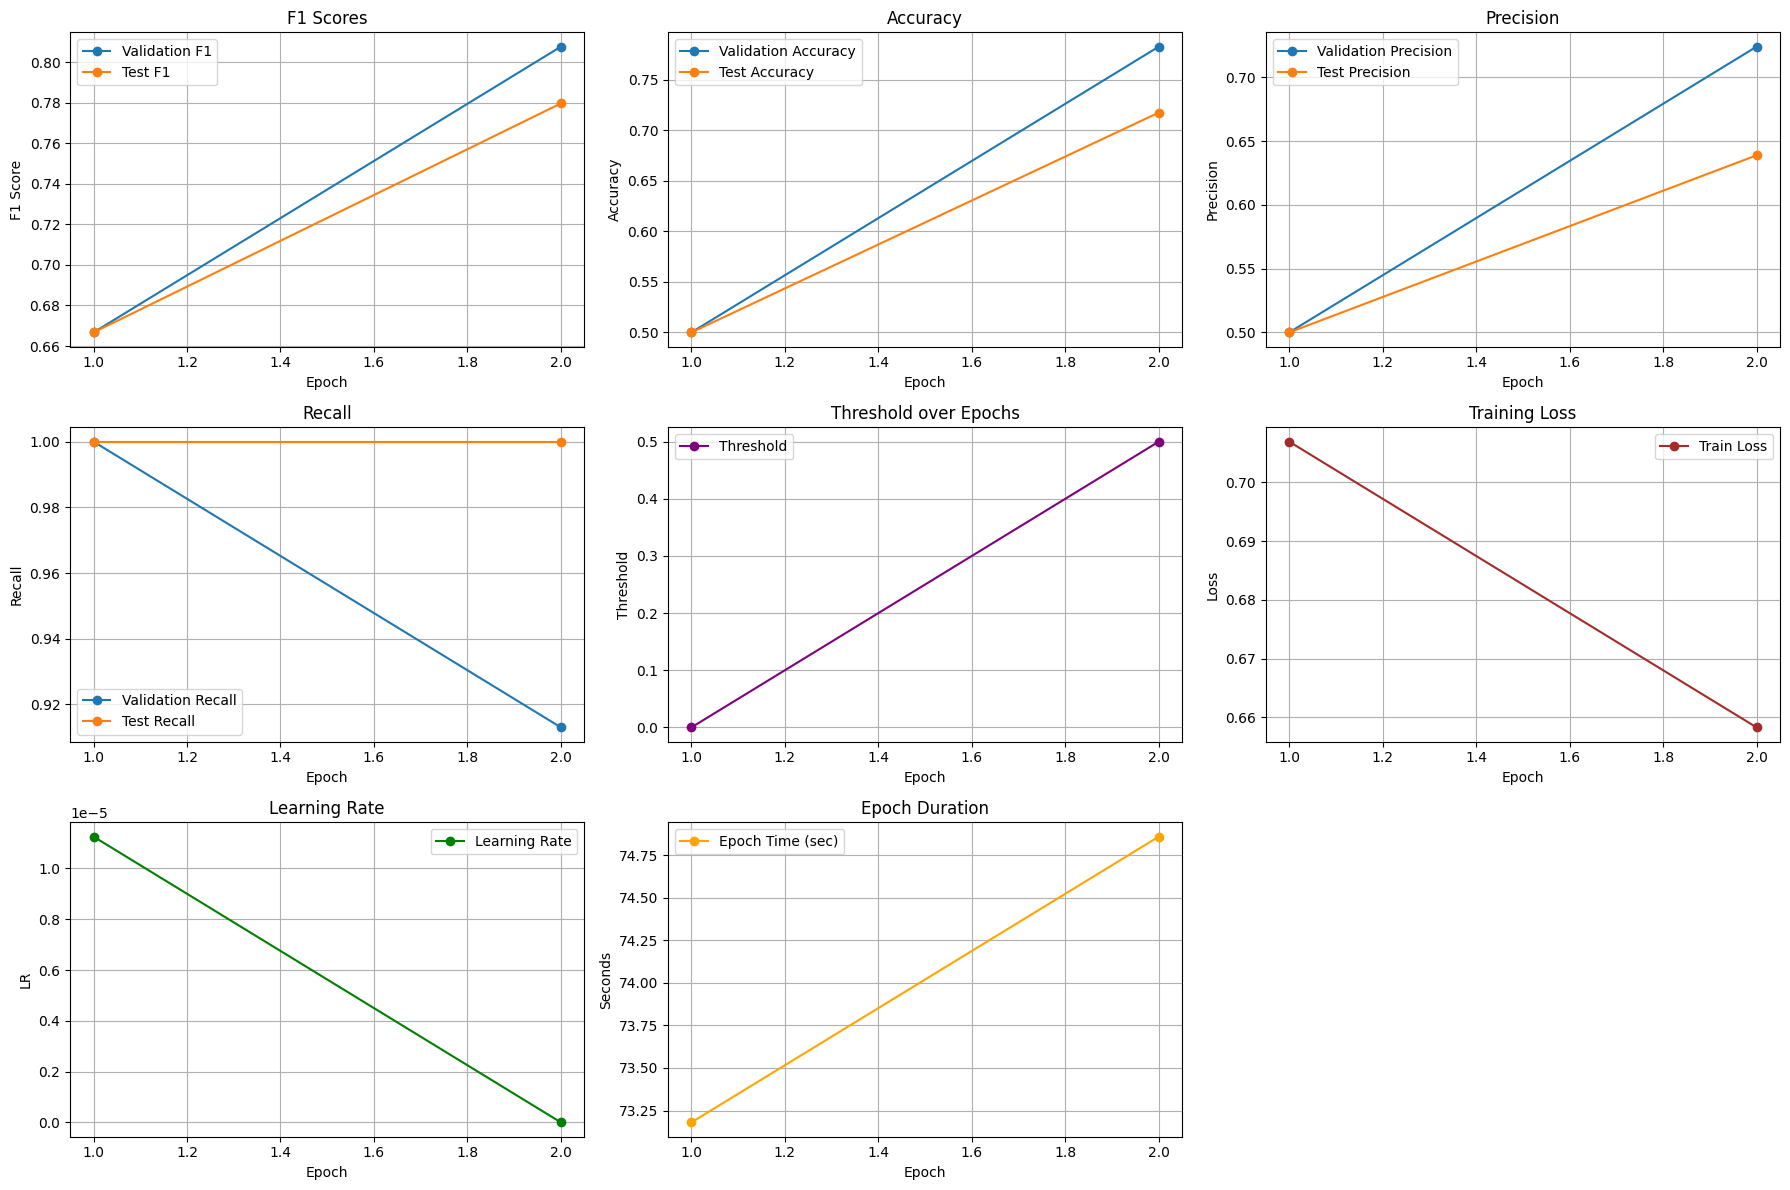

In [42]:
lm_name = hp.lm.replace('/', '_').replace('-', '_')
csv_filename = f"bs{hp.batch_size}_ep{hp.epochs}_lm{lm_name}_alpha{hp.alpha_aug}.csv"
csv_log_path = os.path.join(hp.base_path_blocking ,hp.logdir, hp.task, csv_filename)
plot_metrics(csv_log_path)